In [ ]:
Konu      : Yüz ifadesi tanıma
Ders      : BİTİRME ÇALIŞMASI
Yöntem    : CNN/MobileNet/Resnet
Veri seti : FER2013
Öğrenci numarası:G201210568

# import required packages

In [ ]:
# import required packages
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.backend as K
%matplotlib inline

# Data Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Input, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2, ResNet50

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# ignoring warnings
import warnings
warnings.filterwarnings('ignore')


# Preparing the data

### Load Images from Directories

In [ ]:
import os
import cv2
import numpy as np

def load_images_from_directory(directory, target_size=(48, 48)):
    data_list = os.listdir(directory)
    class_images = {dataset: [] for dataset in data_list}
    label_dict = {dataset: idx for idx, dataset in enumerate(data_list)}

    for dataset in data_list:
        img_list = os.listdir(os.path.join(directory, dataset))
        for img in img_list:
            input_img = cv2.imread(os.path.join(directory, dataset, img))
            input_img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            input_img_resized = cv2.resize(input_img_gray, target_size)
            input_img_resized = np.expand_dims(input_img_resized, axis=-1)
            class_images[dataset].append(input_img_resized)
    
    return class_images, label_dict

# Paths for Kaggle environment
data_path = "/kaggle/input/archive/archive"
train_path = os.path.join(data_path, "train")

# Load images from the directories
train_class_images, train_label_dict = load_images_from_directory(train_path)


### Visualize Class Distribution

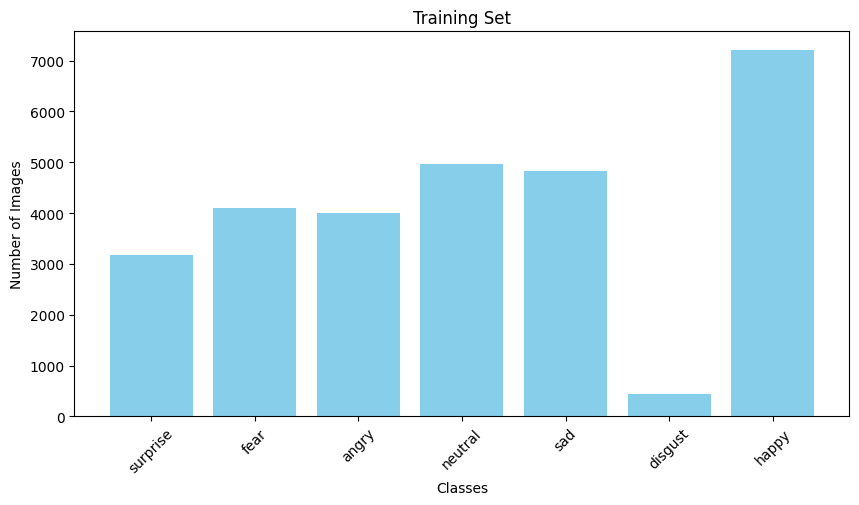

In [6]:
def visualize_class_distribution(class_images, title):
    class_count = {class_name: len(images) for class_name, images in class_images.items()}
    plt.figure(figsize=(10, 5))
    plt.bar(class_count.keys(), class_count.values(), color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Visualize the data
visualize_class_distribution(train_class_images, 'Training Set')

# Apply Augmentation to 'Disgust' Class

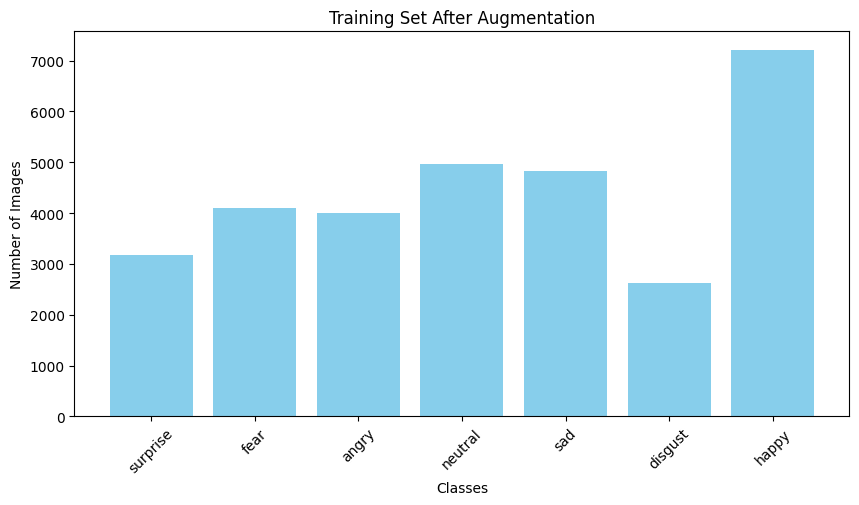

In [10]:
def augment_images(images, augmentation_params, num_augmented=5):
    datagen = ImageDataGenerator(**augmentation_params)
    augmented_images = []
    for img in images:
        img_array = np.expand_dims(img, axis=0)  # Expand dims to make it (1, 48, 48, 1)
        i = 0
        for batch in datagen.flow(img_array, batch_size=1):
            augmented_images.append(batch[0].reshape(48, 48, 1))
            i += 1
            if i >= num_augmented:  # Generate specified number of augmented images per original image
                break
    return augmented_images

augmentation_params = {
    'rotation_range': 15,
    'width_shift_range': 0.05,
    'height_shift_range': 0.05,
    'shear_range': 0.05,
    'zoom_range': 0.05,
    'horizontal_flip': True
}

# Apply augmentation for 'disgust' class
if 'disgust' in train_class_images:
    augmented_images = augment_images(train_class_images['disgust'], augmentation_params)
    train_class_images['disgust'].extend(augmented_images)
    
# Visualize the data after augmentation
visualize_class_distribution(train_class_images, 'Training Set After Augmentation')

### Data Preprocessing

In [11]:
# Convert lists of images to numpy arrays and normalize
train_data = []
for images in train_class_images.values():
    train_data.extend(images)
train_data = np.array(train_data).astype('float64') / 255.0

# Convert labels to numpy arrays and one-hot encode
num_classes = len(train_label_dict)

train_labels = []
for class_name, images in train_class_images.items():
    train_labels.extend([train_label_dict[class_name]] * len(images))
train_labels = np.array(train_labels)
train_img_labels = to_categorical(train_labels, num_classes)

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_img_labels, test_size=0.2, random_state=42)


# Print the shapes to confirm
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_val shape: {Y_val.shape}")

X_train shape: (24711, 48, 48, 1)
X_val shape: (6178, 48, 48, 1)
Y_train shape: (24711, 7)
Y_val shape: (6178, 7)


# Visualize some samples

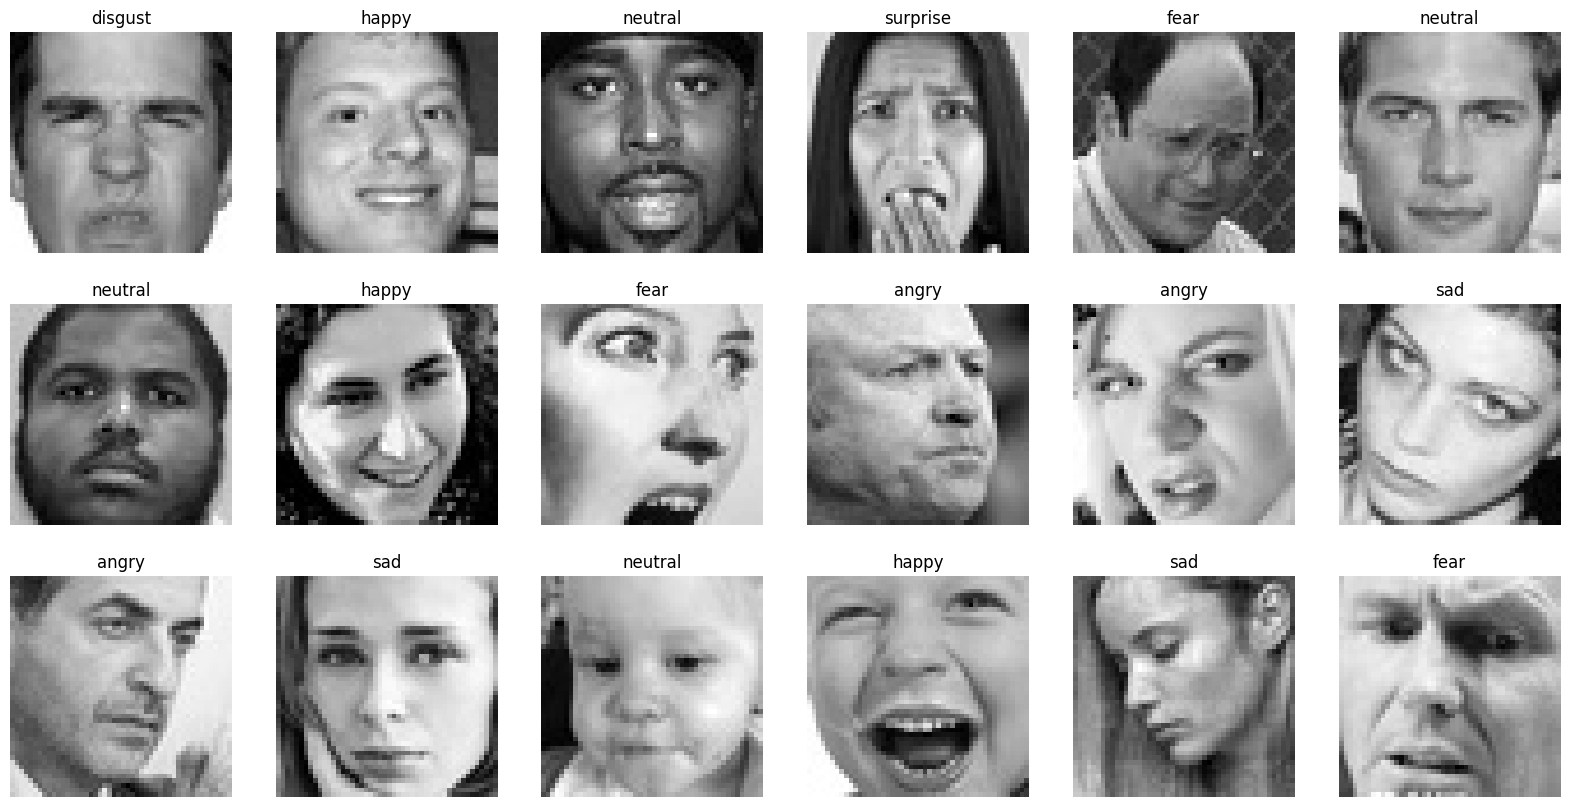

In [12]:
# Visualize some samples from the training dataset
plt.figure(figsize=(20, 10))
for i, j in enumerate(np.random.randint(0, len(X_train), 18)):
    plt.subplot(3, 6, i + 1)
    plt.imshow(X_train[j].squeeze(), cmap='gray')
    plt.axis("off")
    plt.title(list(train_label_dict.keys())[list(train_label_dict.values()).index(np.argmax(Y_train[j]))])
plt.show()

In [13]:
def build_model(input_shape, num_classes):
    # Define the model architecture
    model = Sequential()

    # Add a convolutional layer with 32 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
    # Add a batch normalization layer
    model.add(BatchNormalization())

    # Add a second convolutional layer with 64 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    # Add a second batch normalization layer
    model.add(BatchNormalization())
    # Add a max pooling layer with 2x2 pool size
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Add a third convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    # Add a third batch normalization layer
    model.add(BatchNormalization())

    # Add a fourth convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Add a fifth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    # Add a sixth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    # Add a sixth batch normalization layer
    model.add(BatchNormalization())
    # Add a max pooling layer with 2x2 pool size
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten the output of the convolutional layers
    model.add(Flatten())
    # Add a dense layer with 256 neurons and relu activation function
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # Add a dense layer with 7 neurons (one for each class) and softmax activation function
    model.add(Dense(7, activation='softmax'))

    return model
# Compile the model with categorical cross-entropy loss, adam optimizer, and accuracy metric
cnn_model = build_model(input_shape=(48, 48, 1), num_classes=7)

I0000 00:00:1745769857.860028      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
#Compile the Model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
# Fit the model with early stopping
cnn_history = cnn_model.fit(X_train, Y_train, epochs=100, validation_data=(X_val, Y_val), callbacks=[early_stopping])